# Building our First Model

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import collections
import pandas as pd
import seaborn as sns
import time
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load in our train dataset's mean and standard deviation values we calculated previously.

In [3]:
mean = np.array([0.6760, 0.6308, 0.5746])
std = np.array([0.2055, 0.2108, 0.2250])

In [4]:
data_dir = 'garbage'
sets = ['train', 'test']

Define transformations. We may need to adjust the image size from Resize.

In [5]:
data_transforms = {
    'train':transforms.Compose([
        transforms.Resize(size=(150, 300)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'test':transforms.Compose([
        transforms.Resize(size=(150, 300)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
}

In [26]:
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
#                   for x in sets}

In [6]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, sets[0]), transform=data_transforms['train'])

Let's find out the distribution of our classes in the training dataset.

In [7]:
class_label_encoding_dict = train_dataset.class_to_idx
class_label_encoding_dict

{'PET': 0,
 'books_and_paper': 1,
 'burnable': 2,
 'cans': 3,
 'cardboard': 4,
 'clothes': 5,
 'danger': 6,
 'glass_bin': 7,
 'metal': 8,
 'nonburn': 9,
 'plastic': 10}

In [8]:
class_distribution = dict(collections.Counter(train_dataset.targets))
class_distribution

{0: 1450,
 1: 2843,
 2: 17197,
 3: 1722,
 4: 1944,
 5: 5346,
 6: 945,
 7: 2447,
 8: 1247,
 9: 3959,
 10: 1935}

In [9]:
for i, key in enumerate(class_label_encoding_dict.keys(), start=0):
    class_label_encoding_dict[key] = class_distribution[i]
class_label_encoding_dict

{'PET': 1450,
 'books_and_paper': 2843,
 'burnable': 17197,
 'cans': 1722,
 'cardboard': 1944,
 'clothes': 5346,
 'danger': 945,
 'glass_bin': 2447,
 'metal': 1247,
 'nonburn': 3959,
 'plastic': 1935}

Text(0.5, 1.0, 'Train Dataset Class Distribution')

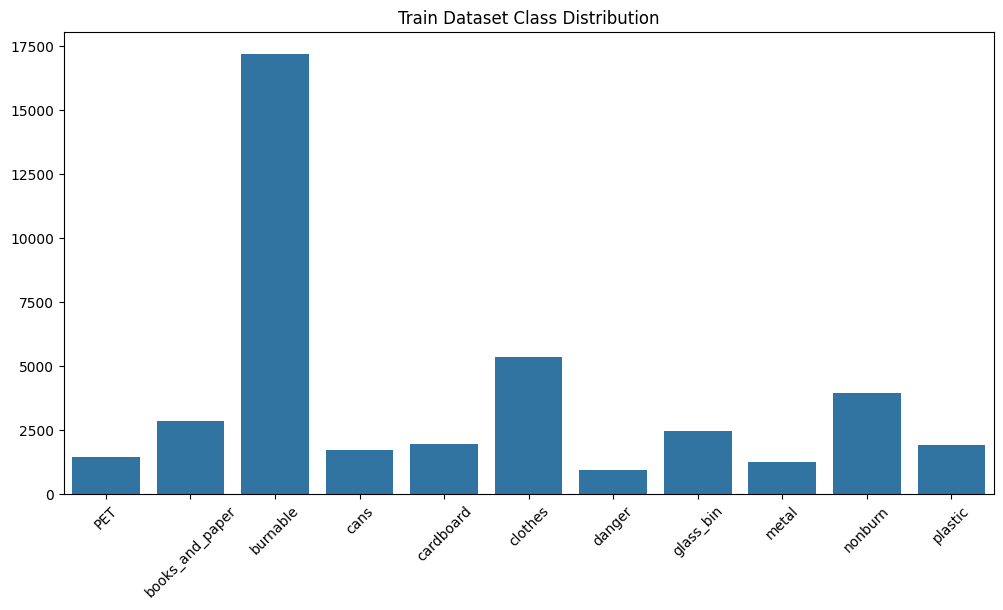

In [10]:
plt.figure(figsize=(12,6))
sns.barplot(class_label_encoding_dict)
plt.xticks(rotation=45)
plt.title('Train Dataset Class Distribution')

In [11]:
for key, value in class_label_encoding_dict.items():
    print(f'Dataset is {round(value/len(train_dataset)*100,2)}% {key}')

Dataset is 3.53% PET
Dataset is 6.93% books_and_paper
Dataset is 41.91% burnable
Dataset is 4.2% cans
Dataset is 4.74% cardboard
Dataset is 13.03% clothes
Dataset is 2.3% danger
Dataset is 5.96% glass_bin
Dataset is 3.04% metal
Dataset is 9.65% nonburn
Dataset is 4.72% plastic


In [12]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=32)

In [13]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 150, 300])
tensor([ 7,  2,  2,  2,  2, 10,  2,  1,  2,  2,  9,  2,  5,  2,  8,  4,  2,  9,
         2,  1,  1,  4, 10,  1,  2,  9,  2,  5,  0,  6,  2,  1])


Text(0.5, 1.0, 'Training Image Sample')

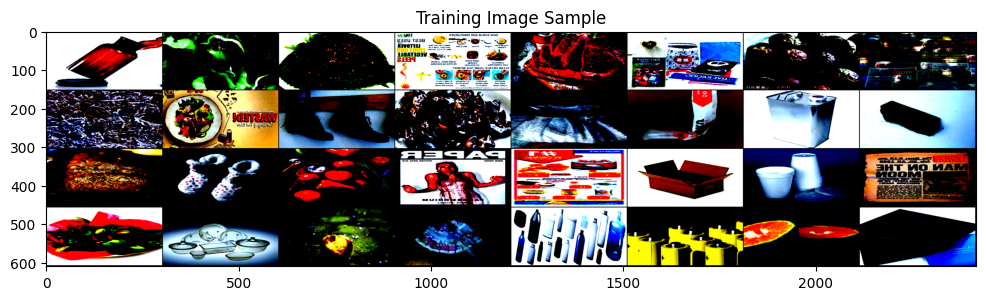

In [14]:
images, labels = next(iter(train_dataloader))
print(images.shape)
print(labels)
plt.figure(figsize=(12,6))
imshow(torchvision.utils.make_grid(images))
plt.title('Training Image Sample')

In [15]:
dataset_size = len(train_dataset)
dataset_size

41035

Define a training loop.

In [81]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        print('-'*10)

        # # each epoch has a training and validation phase
        # for phase in ['train', 'val']:
        #     if phase == 'train':
        #         model.train() # set model to training mode
        #     else:
        #         model.eval() # set model to validation mode

        running_loss = 0.0
        running_corrects = 0

            # Iterate over data
        for i, (inputs, labels) in enumerate(train_dataloader):
            print(f'Working on batch {i+1}/{len(train_dataloader)} in epoch {epoch+1}')
            inputs = inputs.to(device)
            labels = labels.to(device)

            #forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running loss with outputs of training batch
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size

        print(f'Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_weights = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model


Load in the pretrained VGG16 model with weights.

In [82]:
model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)

In [83]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Freeze model parameters.

In [84]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [85]:
# Check how many features are input to the final linear layer of the model
num_features = model.classifier[6].in_features
num_features

4096

In [86]:
model.classifier[6] = torch.nn.Linear(in_features=num_features, out_features=11)

In [87]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [88]:
for param in model.classifier.parameters(): # freeze all the model parameters in the features part
    param.requires_grad = False

In [89]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

The learning rate scheduler will decrease the learning rate as the epoch number increases.

In [90]:
exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)

In [91]:
model = train_model(model=model, criterion=criterion, optimizer=optimizer,
                    scheduler=exp_lr_scheduler, num_epochs=2)

Epoch: 1/2
----------
Working on batch 1/1283 in epoch 1
Working on batch 2/1283 in epoch 1
Working on batch 3/1283 in epoch 1
Working on batch 4/1283 in epoch 1
Working on batch 5/1283 in epoch 1
Working on batch 6/1283 in epoch 1
Working on batch 7/1283 in epoch 1
Working on batch 8/1283 in epoch 1
Working on batch 9/1283 in epoch 1
Working on batch 10/1283 in epoch 1
Working on batch 11/1283 in epoch 1
Working on batch 12/1283 in epoch 1
Working on batch 13/1283 in epoch 1
Working on batch 14/1283 in epoch 1
Working on batch 15/1283 in epoch 1
Working on batch 16/1283 in epoch 1
Working on batch 17/1283 in epoch 1
Working on batch 18/1283 in epoch 1
Working on batch 19/1283 in epoch 1
Working on batch 20/1283 in epoch 1
Working on batch 21/1283 in epoch 1
Working on batch 22/1283 in epoch 1
Working on batch 23/1283 in epoch 1
Working on batch 24/1283 in epoch 1
Working on batch 25/1283 in epoch 1
Working on batch 26/1283 in epoch 1
Working on batch 27/1283 in epoch 1


KeyboardInterrupt: 